# Itterative methods for the Solution of the Laplace Equation

In this workbook we are going to look at the Jacobi, Gauss-Siedel and SOR methods for the solution of the Laplace equations.  These methods all make use of the 2nd order central difference approximation to the 2nd derivative

$$\frac{\partial^2 u}{\partial x^2} = \frac{u_W-2u_O+u_E}{\Delta x^2}+O(\Delta x^2)$$

Before we begin we are going to need the numpy and matplotlib python libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

## Grid tools
In order to be able to solve the problem we need some tools to create a grid.  We're going to use a class to do this.  For now our class will contain routines to set up the grid, specify the bottom left coordinate (origin) and the top right coordinate (extent), generate a uniform grid, calculate Δx and Δy and find the array index for a particular (x,y) point.

In [4]:
class Grid:
    '''Class defining a 2D computational grid'''
    
    def __init__(self,ni,nj):
        # set up information about the grid
        self.origin = (0.0, 0.0)  # bottom left
        self.extent = (1.0, 1.0)  # top right
        self.Ni = ni # grid points in i direction
        self.Nj = nj # grid points in j direction
        
        # initialse x,y and u arrays
        self.u = np.zeros((nj, ni))
        self.x = np.zeros((nj, ni))
        self.y = np.zeros((nj, ni))

    def set_origin(self,x0,y0):
        '''Specity the location of the bottom left corner of the grid'''
        self.origin = (x0, y0)
    
    def set_extent(self,x1,y1):
        '''Specity the width and height of the grid'''
        self.extent = (x1, y1)
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        origin to the extent.  We are going to do this using linspace from
        numpy to create lists of x and y ordinates and then the meshgrid
        function to turn these into 2D arrays of grid point ordinates.'''
        x_ord = np.linspace(self.origin[0], self.extent[0], self.Ni)
        y_ord = np.linspace(self.origin[1], self.extent[1], self.Nj)
        self.x, self.y = np.meshgrid(x_ord,y_ord)
        if not Quiet:
            print(self)

    def Delta_x(self):
        # calculate delta x
        return self.x[0,1]-self.x[0,0]
    
    def Delta_y(self):
        # calculate delta y
        return self.y[1,0]-self.y[0,0]
    
    def find(self,point):
        '''find the i and j ordinates of the grid cell which contains 
        the point (x,y).  To do this we calculate the distance from
        the point to the origin in the x and y directions and then
        divide this by delta x and delta y.  The resulting real ordinates
        are converted to indices using the int() function.'''
        grid_x = (point[0] - self.origin[0])/self.Delta_x()
        grid_y = (point[1] - self.origin[1])/self.Delta_y()
        return int(grid_x), int(grid_y)
    
    def __str__(self):
        # describe the object when asked to print it
        return 'Uniform {}x{} grid from {} to {}.'.format(self.Ni, self.Nj, self.origin, self.extent)

In [5]:
# lets now test this
test = Grid(11,11)
test.set_extent(2.0,2.0)
test.generate(Quiet=False)
test.find((1.0,1.0))

Uniform 11x11 grid from (0.0, 0.0) to (2.0, 2.0).


(5, 5)

## The test problem
Before looking at the methods we need a test problem to solve.  In this case we are going to look at example 9.29 from Advanced Modern Engineering Mathematics.  

$$0=u_{xx}+u_{yy}$$
subject to the boundary conditions
$$\begin{align*}
u(x,0)&=0&0\le x\le 2 \\
u(x,1)&=0&0\le x\le 2 \\
u(0,y)&=0&0\le y \le 1\\
u(2,y)&=\sin 2\pi y&0\le y \le 1.
\end{align*}$$

The steps needed to set the problem up are:
1. Generate the grid
2. Initialise the u array
3. Set up the boundary conditions

We are going to create a grid object to do this, together with the methods for discretising the gird, initialising u, setting the boundary conditions and plotting the solution.

In [6]:
def Example929(ni,nj):
    # set up a mesh
    mesh = Grid(ni,nj)
    mesh.set_extent(2.0,1.0)
    mesh.generate()
    # now the RHS boundary condition
    mesh.u[:,-1]=np.sin(2*np.pi*mesh.y[:,-1])
    return mesh

Uniform 21x11 grid from (0.0, 0.0) to (2.0, 1.0).


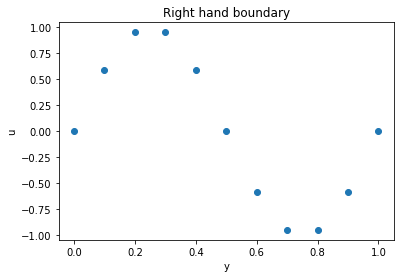

In [7]:
# lets test it
test = Example929(21,11)
print(test)

# and plot the boundary values.
plt.plot(test.y[:,-1],test.u[:,-1],'o')
plt.title('Right hand boundary')
plt.xlabel('y')
plt.ylabel('u')
plt.show()

## The Jacobi Method

We start by discretising the PDE using the central difference approximations, so we have
$$\frac{u_E-2U_O+u_W}{\Delta x^2}+\frac{u_N-2U_O+u_S}{\Delta y^2}=0$$
Rearranging we have
$$u_O=\frac{1}{2(1+\beta^2)}{u_E+u_W+\beta^2(u_N+u_S)}$$
where $$\beta = \frac{\Delta x}{\Delta y}.$$
Suggesting the itterative scheme
$$u_O^{n+1}=\frac{1}{2(1+\beta^2)}\left(u_E^n+u_W^n+\beta^2(u_N^n+u_S^n)\right)$$

Because we have boundary conditions stored in the boundary cells we only need to compute the internal values using the itterative scheme.  We can write this using the whole array opperations.


In [8]:
def Jacobi(mesh,tol=0.5e-7,maxit=10000):
    '''Jacobi itteration applied to the grid stored in mesh.  
    We will continue itterating until the difference between
    u^{n+1} and u^n is less than tol. We will also stop if 
    we have done more than maxit itterations.
    
    The solution stored in the mesh.u variable is updated'''
    
    # calculate the coefficients
    beta = mesh.Delta_x()/mesh.Delta_y()
    beta_sq = beta**2
    C_beta = 1/(2*(1+beta_sq))
    
    # initialise u_new 
    u_new = mesh.u.copy()
    
    # itteration
    for it in range(maxit):
        # implement the Jacobi method using whole array opperations
        # it is important to note that in Python the arrays are indexed
        # u[j,i], so u[1:-1,:-2] is the west grid point.
        u_new[1:-1,1:-1] = C_beta*(mesh.u[1:-1,:-2]+mesh.u[1:-1,2:]+
                                  beta_sq*(mesh.u[:-2,1:-1]+mesh.u[2:,1:-1]))
        
        # compute the difference between the new and old solutions
        err = np.max(mesh.u-u_new)/np.max(mesh.u)
        
        # update the solution
        mesh.u = np.copy(u_new)
        
        # converged?
        if err < tol:
            break
    
    if it+1 == maxit:
        print('Jacobi itteration failed to converge, error = {}'.format(err))
    
    return it+1, err # return the number of itterations and the final residual


Converged after 107 itterations, final residual is 4.895922258405755e-08


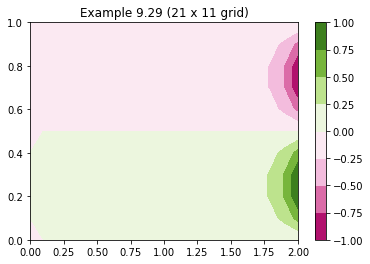

In [9]:
# lets test it
itt, err = Jacobi(test)
print('Converged after {} itterations, final residual is {}'.format(itt,err))

# plot the solution
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('PiYG')
cf = ax1.contourf(test.x,test.y,test.u,cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title(f'Example 9.29 ({test.Ni} x {test.Nj} grid)')
plt.show()

Converged after 1329 itterations, final residual is 4.9689083025244996e-08


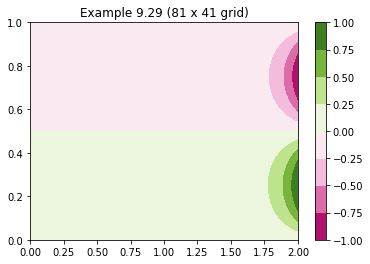

In [10]:
# What about a finer grid
test2 = Example929(81,41)
itt, err = Jacobi(test2)
print('Converged after {} itterations, final residual is {}'.format(itt,err))

# plot the solution
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('PiYG')
cf = ax1.contourf(test2.x,test2.y,test2.u,cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title(f'Example 9.29 ({test2.Ni} x {test2.Nj} grid)')
plt.show()

Solver took 0.582 seconds.
Converged after 4523 itterations, final residual is 4.9924588005345605e-08


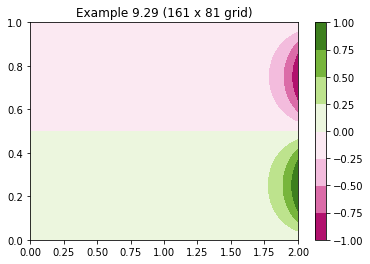

In [12]:
# What about a finer still grid
test3 = Example929(161,81)

# we will time it
start = time.process_time()
itt, err = Jacobi(test3)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))
print('Converged after {} itterations, final residual is {}'.format(itt,err))

# plot the solution
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('PiYG')
cf = ax1.contourf(test3.x,test3.y,test3.u,cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title(f'Example 9.29 ({test3.Ni} x {test3.Nj} grid)')
plt.show()

## Gauss-Seidel
In the Jacobi scheme we used
$$u_O^{n+1}=\frac{1}{2(1+\beta^2)}\left(u_E^n+u_W^n+\beta^2(u_N^n+u_S^n)\right).$$
However, we know that the west and south values of u are already know.  This means we could use
$$u_O^{n+1}=\frac{1}{2(1+\beta^2)}\left(u_E^n+u_W^{n+1}+\beta^2(u_N^n+u_S^{n+1})\right).$$
which should speed up convegence.

Unfortunately this means we can't write the loops using whole array opperations as the 

      u_new[1:-1,1:-1] = C_beta*(mesh.u[:-2,1:-1]+mesh.u[2:,1:-1]+
                                  beta_sq*(mesh.u[1:-1,:-2]+mesh.u[1:-1,2:]))

syntax implies that the calculations can be performed in any order.  While the pipelining system inside the processor (a kind of arithmetic production line) means that the value of u(i-1,j) whill not have been calculated when we are computing u(i,j).  All this means that although Guass-Sidel will use less itterations it will be slower.

In [13]:
def GaussSeidel(mesh,tol=0.5e-7,maxit=10000):
    '''Gauss-Seidel itteration applied to the grid stored in mesh.  
    We will continue itterating until the difference between
    u^{n+1} and u^n is less than tol. We will also stop if 
    we have done more than maxit itterations.
    
    The solution stored in the mesh.u variable is updated'''

    # calculate the coefficients
    beta = mesh.Delta_x()/mesh.Delta_y()
    beta_sq = beta**2
    C_beta = 1/(2*(1+beta_sq))
    
    # initialise u_new 
    u_new = mesh.u.copy()
    
    # itteration
    for it in range(maxit):
        for j in range(1,mesh.Nj-1):
            for i in range(1,mesh.Ni-1):
                u_new[j,i] = C_beta*(u_new[j-1,i]+u_new[j+1,i]+
                                  beta_sq*(u_new[j,i-1]+u_new[j,i+1]))
        
        # compute the difference between the new and old solutions
        err = np.max(mesh.u-u_new)/np.max(mesh.u)
        
        # update the solution
        mesh.u = np.copy(u_new)
        
        # converged?
        if err < tol:
            break
    
    if it+1 == maxit:
        print('Gauss-Seidel itteration failed to converge, error = {}'.format(err))
    
    return it+1, err # return the number of itterations and the final residual



Solver took 46.4 seconds.
Converged after 3248 itterations, final residual is 4.998517932376656e-08


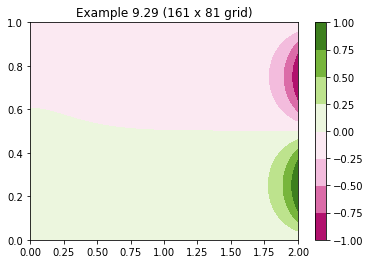

In [14]:
# Let's try test that fine grid again
test_GS = Example929(161,81)

# we will time it
start = time.process_time()
itt, err = GaussSeidel(test_GS)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))
print('Converged after {} itterations, final residual is {}'.format(itt,err))

# plot the solution
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('PiYG')
cf = ax1.contourf(test_GS.x,test_GS.y,test_GS.u,cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title(f'Example 9.29 ({test_GS.Ni} x {test_GS.Nj} grid)')
plt.show()

### Analysis
Although the number of itterations is 70% less, the run time is 77 times larger.  It is possible to reduce this futher by carefull writing of the main loop, but not having access to the processor pipeline is a big price to pay.

We can speed things up further using the SOR itteration

## Sucessive Over Relaxation

In SOR we take a weighted average of the old and new values of u.
$$u_O^{n+1}=(1-\omega)u_O^n+\frac{\omega}{2(1+\beta^2)}\left(u_E^n+u_W^{n+1}+\beta^2(u_N^n+u_S^{n+1})\right).$$
where 1 ⩽ ω < 2.  The optimal value of ω is:
$$\omega = \frac{2}{1+\sqrt{1-\lambda}}$$
where λ is the dominant Eigenvalue of the itteration matrix.  On a regular Cartesian grid this is
$$\lambda = \frac{1}{4}\left(\cos\frac\pi{N_i}+\cos\frac\pi{N_J}\right)^2$$



In [15]:
def SOR(mesh,tol=0.5e-7,maxit=10000):
    '''SOR itteration applied to the grid stored in mesh.  
    We will continue itterating until the difference between
    u^{n+1} and u^n is less than tol. We will also stop if 
    we have done more than maxit itterations.
    
    The solution stored in the mesh.u variable is updated'''

    # calculate the optimal value of omega
    lamda = (np.cos(np.pi/mesh.Ni)+np.cos(np.pi/mesh.Nj))**2/4
    omega = 2/(1+np.sqrt(1-lamda))
    
    # calculate the coefficients
    beta = mesh.Delta_x()/mesh.Delta_y()
    beta_sq = beta**2
    C_beta = 1/(2*(1+beta_sq))
    
    # initialise u_new 
    u_new = mesh.u.copy()
    
    # itteration
    for it in range(maxit):
        for j in range(1,mesh.Nj-1):
            for i in range(1,mesh.Ni-1):
                u_new[j,i] = (1-omega)*mesh.u[j,i] + \
                        omega * C_beta*(u_new[j-1,i]+mesh.u[j+1,i]+ \
                        beta_sq*(u_new[j,i-1]+mesh.u[j,i+1]))
        
        # compute the difference between the new and old solutions
        err = np.max(mesh.u-u_new)/np.max(mesh.u)
        
        # update the solution
        mesh.u = np.copy(u_new)
        
        # converged?
        if err < tol:
            break
    
    if it+1 == maxit:
        print('SOR itteration failed to converge, error = {}'.format(err))
    
    return it+1, err # return the number of itterations and the final residual


Solver took 8.07 seconds.
Converged after 330 itterations, final residual is 3.480489877941616e-08


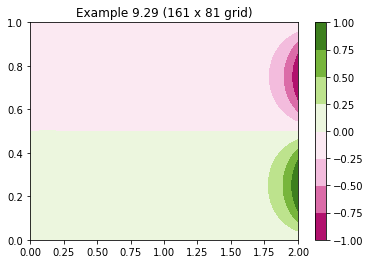

In [16]:
# Let's try test that fine grid again
test_SOR = Example929(161,81)

# we will time it
start = time.process_time()
itt, err = SOR(test_SOR)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))
print('Converged after {} itterations, final residual is {}'.format(itt,err))

# plot the solution
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('PiYG')
cf = ax1.contourf(test_SOR.x,test_SOR.y,test_SOR.u,cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title(f'Example 9.29 ({test_SOR.Ni} x {test_SOR.Nj} grid)')
plt.show()

### Analysis
We have dramatically reduced the number of itterations needed (it's 7% of those needed for Jacobi) but the runtime is still higher.  It's not a conventional approach but we could try SOR-Jacobi to see if we get a rocket powered solver.

In [17]:
def SOR_J(mesh,tol=0.5e-7,maxit=10000):
    '''SOR version of the Jacobi itteration 
    applied to the grid stored in mesh.  
    We will continue itterating until the difference between
    u^{n+1} and u^n is less than tol. We will also stop if 
    we have done more than maxit itterations.
    
    The solution stored in the mesh.u variable is updated'''

    # calculate the optimal value of omega
    lamda = (np.cos(np.pi/mesh.Ni)+np.cos(np.pi/mesh.Nj))**2/4
    omega = 2/(1+np.sqrt(1-lamda))
    
    # calculate the coefficients
    beta = mesh.Delta_x()/mesh.Delta_y()
    beta_sq = beta**2
    C_beta = 1/(2*(1+beta_sq))
    
    # initialise u_new 
    u_new = mesh.u.copy()
    
    # itteration
    for it in range(maxit):
        u_new[1:-1,1:-1] = (1-omega) * mesh.u[1:-1,1:-1] + \
            omega * C_beta*(mesh.u[:-2,1:-1] + mesh.u[2:,1:-1] + \
            beta_sq*(mesh.u[1:-1,:-2] + mesh.u[1:-1,2:]))

        # compute the difference between the new and old solutions
        err = np.max(mesh.u-u_new)/np.max(mesh.u)
        
        # update the solution
        mesh.u = np.copy(u_new)
        
        # converged?
        if err < tol:
            break
    
    if it+1 == maxit:
        print('SOR Jacobi itteration failed to converge, error = {}'.format(err))
    
    return it+1, err # return the number of itterations and the final residual



In [18]:
# Let's try test that fine grid again
test_SORJ = Example929(161,81)

# we will time it
start = time.process_time()
itt, err = SOR_J(test_SORJ)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))
print('Converged after {} itterations, final residual is {}'.format(itt,err))


/var/folders/kc/kvwtcd51499g5czgmyk13js80000gn/T/ipykernel_64942/934759516.py:25: RuntimeWarning: overflow encountered in add
  omega * C_beta*(mesh.u[:-2,1:-1] + mesh.u[2:,1:-1] + \
/var/folders/kc/kvwtcd51499g5czgmyk13js80000gn/T/ipykernel_64942/934759516.py:26: RuntimeWarning: overflow encountered in add
  beta_sq*(mesh.u[1:-1,:-2] + mesh.u[1:-1,2:]))
/var/folders/kc/kvwtcd51499g5czgmyk13js80000gn/T/ipykernel_64942/934759516.py:29: RuntimeWarning: invalid value encountered in double_scalars
  err = np.max(mesh.u-u_new)/np.max(mesh.u)
/var/folders/kc/kvwtcd51499g5czgmyk13js80000gn/T/ipykernel_64942/934759516.py:25: RuntimeWarning: invalid value encountered in add
  omega * C_beta*(mesh.u[:-2,1:-1] + mesh.u[2:,1:-1] + \


SOR Jacobi itteration failed to converge, error = nan
Solver took 1.59 seconds.
Converged after 10000 itterations, final residual is nan


## Analysis

SOR-Jacobi dosen't work!  It failed to converge and we have overflow errors and values of **nan** returned.  **nan** means "not a number" and occurs when we try to use numbers bigger than those that can be represented by the computer, divide by zero, take the square root of a negative number etc.   We say that the method has "blown up"  

So we have choice we can use the **efficient** SOR algorithm or the fast **Jacobi** itteration.  
